In [2]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import scipy.signal as sps
import os, sys
from tessifystarspot import *

In [3]:
k = 892376

In [4]:
kep_cadence = 1/24/2 # 30min cadence
tess_cadence = 1/24/2 # 30min cadence
sos = sps.butter(3, (1/15), 'hp', fs=48, output='sos')

In [5]:
lc_qual = lk.search_lightcurve(f'KIC {k}', quarter=9).download(quality_bitmask=0)
qual_kep = len(np.nonzero(lc_qual.quality.value)[0]) / len(lc_qual.time)

lc = lk.search_lightcurve(f'KIC {k}', quarter=9).download().remove_outliers()
lc = lc.normalize() - 1 # to make butterworth filter work

p_kep = lc.to_periodogram(oversample_factor=50)
ls_kep = p_kep.period_at_max_power.value #rotate_kep.ls_rotation()

lags_kep, acff_kep, _x, _y = simple_acf(lc.time.value, lc.flux.value, kep_cadence, smooth=9, window_length=99, polyorder=3)
try: # to remove in final pipeline, can edit simple_acf to increase lag
    acf_kep = acf_rotation(lc, kep_cadence) # rotate_kep.acf_rotation(kep_cadence)
except IndexError:
    acf_kep = 0

lc_tess = tessify(lc)#, start_modifier=1000)
qual_tess = len(np.nonzero(lc_tess.quality)) / len(lc_tess.time)

p_tess = lc_tess.to_periodogram(oversample_factor=50)
ls_tess = p_tess.period_at_max_power.value #rotate_tess.ls_rotation()

lags_tess, acff_tess, _x, _y = simple_acf(lc_tess.time.value, lc_tess.flux.value, tess_cadence, smooth=9, window_length=99, polyorder=3)
try:
    acf_tess = acf_rotation(lc_tess, tess_cadence)
except IndexError:
    acf_tess = 0
    
newflux = sps.sosfilt(sos, lc.flux.value)
lc.flux = newflux

lc_butter = tessify(lc)#, start_modifier=1000)
p_butter = lc_butter.to_periodogram(oversample_factor=50)
ls_butter = p_butter.period_at_max_power.value #rotate_tess.ls_rotation()

lags_butter, acff_butter, _x, _y = simple_acf(lc_butter.time.value, lc_butter.flux.value, tess_cadence, smooth=9, window_length=99, polyorder=3)
try:
    acf_butter = acf_rotation(lc_butter, tess_cadence)
except IndexError:
    acf_butter = 0

/home/isy/.local/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/isy/.local/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [6]:
mosaic = """
    AA
    BC
    DE
"""

<IPython.core.display.Javascript object>


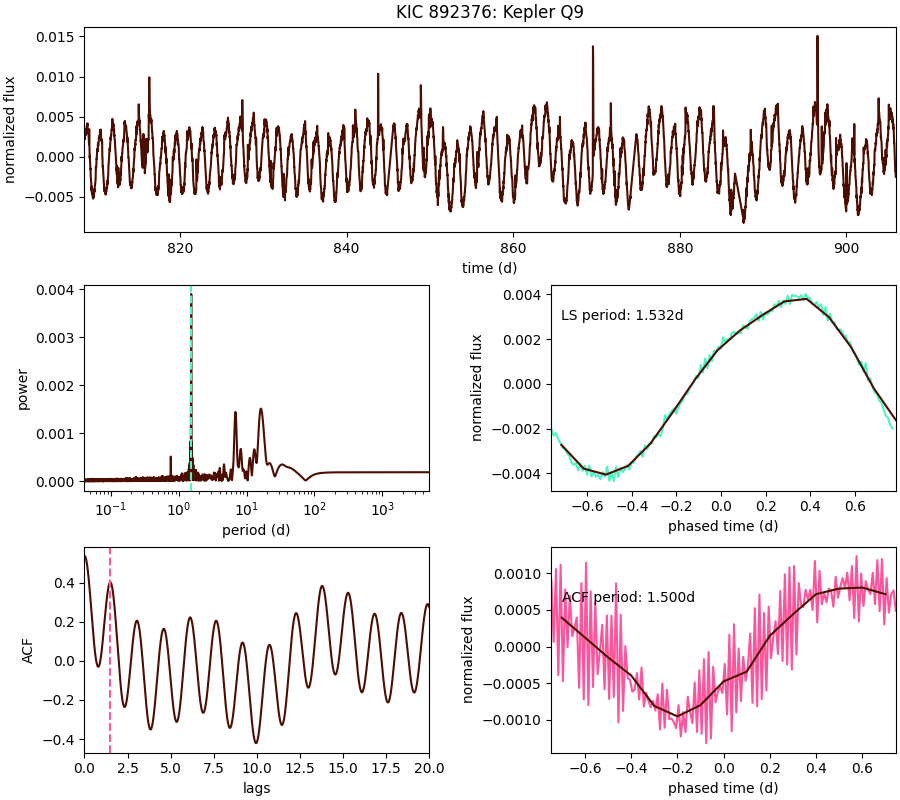

In [15]:
# KEP PLOT
%matplotlib notebook
fig = plt.figure(constrained_layout=True)
ax = fig.subplot_mosaic(mosaic)

ax['A'].plot(lc.time.value, lc.flux.value, c='#4d0e02')
ax['A'].set(xlabel='time (d)', ylabel='normalized flux', title=f'KIC {k}: Kepler Q9', xlim=(min(lc.time.value), max(lc.time.value)))

ax['B'].plot(1/p_kep.frequency.value, p_kep.power.value, c='#4d0e02')
ax['B'].axvline(ls_kep, c='#4ef5c0', ls='--')
ax['B'].set(xscale='log', xlabel='period (d)', ylabel='power', xlim=(min(1/p_kep.frequency.value), max(1/p_kep.frequency.value)))

folded = lc.fold(ls_kep)
binned1a = folded.bin(time_bin_size=0.01)
binned1b = folded.bin(time_bin_size=0.1)
ax['C'].plot(binned1a.time.value, binned1a.flux.value, c='#4ef5c0')
ax['C'].plot(binned1b.time.value, binned1b.flux.value, c='#4d0e02')
xtext = min(binned1b.time.value)
ytext = 0.75 * max(binned1b.flux.value)
xlower = min(min(binned1a.time.value), min(binned1b.time.value))
xupper = max(max(binned1a.time.value), max(binned1b.time.value))
ax['C'].annotate(f'LS period: {ls_kep:.3f}d', (xtext, ytext))
ax['C'].set(xlabel='phased time (d)', ylabel='normalized flux', xlim=(xlower, xupper))

ax['D'].plot(lags_kep, acff_kep, c='#4d0e02')
ax['D'].axvline(acf_kep, c='#ff549b', ls='--')
ax['D'].set(xlim=(0,20), xlabel='lags', ylabel='ACF')

folded2 = lc.fold(acf_kep)
binned2a = folded2.bin(time_bin_size=0.01)
binned2b = folded2.bin(time_bin_size=0.1)
ax['E'].plot(binned2a.time.value, binned2a.flux.value, c='#ff549b')
ax['E'].plot(binned2b.time.value, binned2b.flux.value, c='#4d0e02')
xtext2 = min(binned2b.time.value)
ytext2 = 0.75 * max(binned2b.flux.value)
xlower2 = min(min(binned2a.time.value), min(binned2b.time.value))
xupper2 = max(max(binned2a.time.value), max(binned2b.time.value))
ax['E'].annotate(f'ACF period: {acf_kep:.3f}d', (xtext2, ytext2))
ax['E'].set(xlabel='phased time (d)', ylabel='normalized flux', xlim=(xlower2, xupper2))

fig.set_size_inches(9,8)

fig.savefig('bbbb.png')

<IPython.core.display.Javascript object>


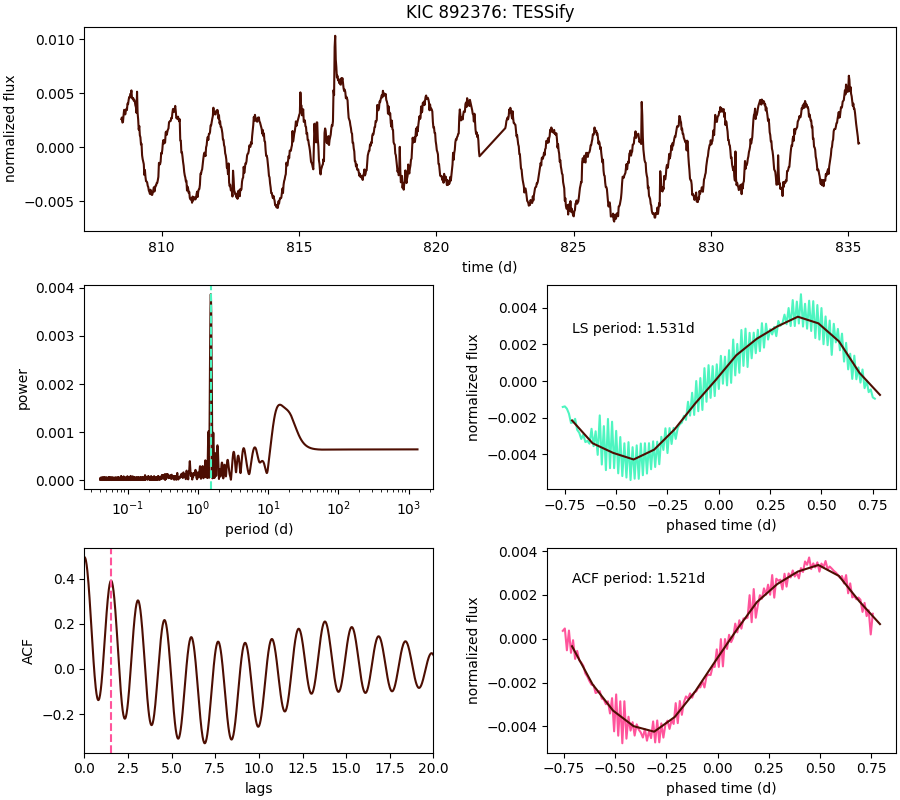

In [61]:
# TESS PLOT
fig = plt.figure(constrained_layout=True)
ax = fig.subplot_mosaic(mosaic)#, gridspec_kw={"height_ratios":[1,0.3,0.2,0.2,0.2]})

ax['A'].plot(lc_tess.time.value, lc_tess.flux.value, c='#4d0e02')
ax['A'].set(xlabel='time (d)', ylabel='normalized flux', title=f'KIC {k}: TESSify')

ax['B'].plot(1/p_tess.frequency.value, p_tess.power.value, c='#4d0e02')
ax['B'].axvline(ls_tess, c='#4ef5c0', ls='--')
ax['B'].set(xscale='log', xlabel='period (d)', ylabel='power')

folded = lc_tess.fold(ls_tess)
ax['C'].plot(folded.bin(time_bin_size=0.01).time.value, folded.bin(time_bin_size=0.01).flux.value, c='#4ef5c0')
ax['C'].plot(folded.bin(time_bin_size=0.1).time.value, folded.bin(time_bin_size=0.1).flux.value, c='#4d0e02')
xtext = min(folded.bin(time_bin_size=0.1).time.value)
ytext = 0.75 * max(folded.bin(time_bin_size=0.1).flux.value)
ax['C'].annotate(f'LS period: {ls_tess:.3f}d', (xtext, ytext))
ax['C'].set(xlabel='phased time (d)', ylabel='normalized flux')

ax['D'].plot(lags_tess, acff_tess, c='#4d0e02')
ax['D'].axvline(acf_tess, c='#ff549b', ls='--')
ax['D'].set(xlim=(0,20), xlabel='lags', ylabel='ACF')

folded2 = lc_tess.fold(acf_tess)
ax['E'].plot(folded2.bin(time_bin_size=0.01).time.value, folded2.bin(time_bin_size=0.01).flux.value, c='#ff549b')
ax['E'].plot(folded2.bin(time_bin_size=0.1).time.value, folded2.bin(time_bin_size=0.1).flux.value, c='#4d0e02')
xtext2 = min(folded2.bin(time_bin_size=0.1).time.value)
ytext2 = 0.75 * max(folded2.bin(time_bin_size=0.1).flux.value)
ax['E'].annotate(f'ACF period: {acf_tess:.3f}d', (xtext2, ytext2))
ax['E'].set(xlabel='phased time (d)', ylabel='normalized flux')

fig.set_size_inches(9,8)

<IPython.core.display.Javascript object>


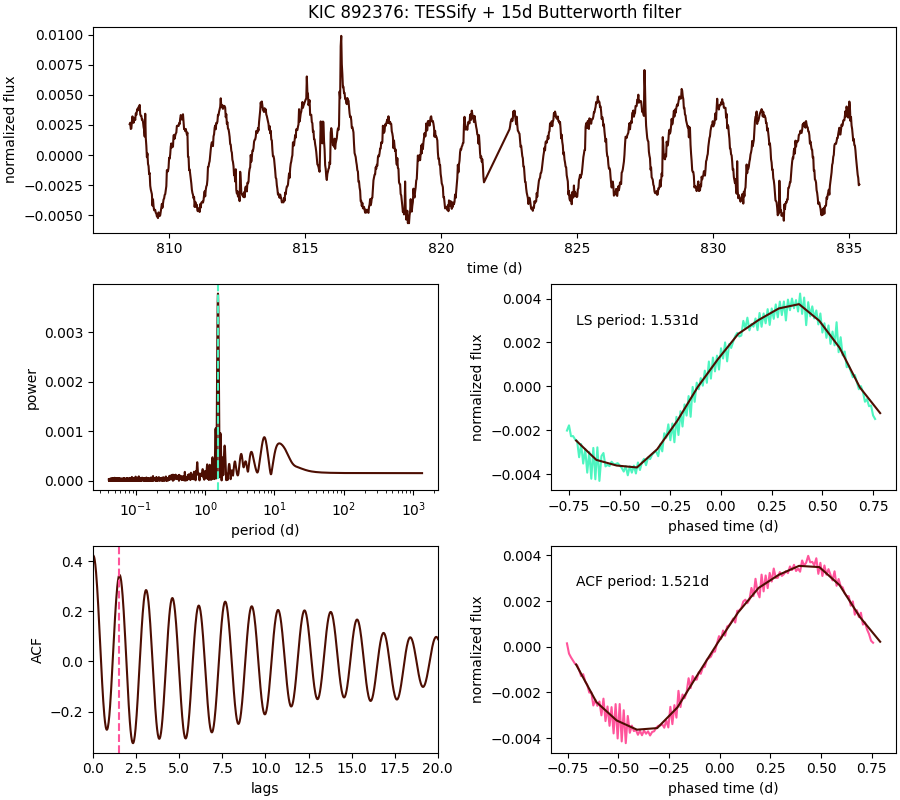

In [60]:
# BUTTER PLOT
fig = plt.figure(constrained_layout=True)
ax = fig.subplot_mosaic(mosaic)#, gridspec_kw={"height_ratios":[1,0.3,0.2,0.2,0.2]})

ax['A'].plot(lc_butter.time.value, lc_butter.flux.value, c='#4d0e02')
ax['A'].set(xlabel='time (d)', ylabel='normalized flux', title=f'KIC {k}: TESSify + 15d Butterworth filter')

ax['B'].plot(1/p_butter.frequency.value, p_butter.power.value, c='#4d0e02')
ax['B'].axvline(ls_butter, c='#4ef5c0', ls='--')
ax['B'].set(xscale='log', xlabel='period (d)', ylabel='power')

folded = lc_butter.fold(ls_butter)
ax['C'].plot(folded.bin(time_bin_size=0.01).time.value, folded.bin(time_bin_size=0.01).flux.value, c='#4ef5c0')
ax['C'].plot(folded.bin(time_bin_size=0.1).time.value, folded.bin(time_bin_size=0.1).flux.value, c='#4d0e02')
xtext = min(folded.bin(time_bin_size=0.1).time.value)
ytext = 0.75 * max(folded.bin(time_bin_size=0.1).flux.value)
ax['C'].annotate(f'LS period: {ls_butter:.3f}d', (xtext, ytext))
ax['C'].set(xlabel='phased time (d)', ylabel='normalized flux')

ax['D'].plot(lags_butter, acff_butter, c='#4d0e02')
ax['D'].axvline(acf_butter, c='#ff549b', ls='--')
ax['D'].set(xlim=(0,20), xlabel='lags', ylabel='ACF')

folded2 = lc_butter.fold(acf_butter)
ax['E'].plot(folded2.bin(time_bin_size=0.01).time.value, folded2.bin(time_bin_size=0.01).flux.value, c='#ff549b')
ax['E'].plot(folded2.bin(time_bin_size=0.1).time.value, folded2.bin(time_bin_size=0.1).flux.value, c='#4d0e02')
xtext2 = min(folded2.bin(time_bin_size=0.1).time.value)
ytext2 = 0.75 * max(folded2.bin(time_bin_size=0.1).flux.value)
ax['E'].annotate(f'ACF period: {acf_butter:.3f}d', (xtext2, ytext2))
ax['E'].set(xlabel='phased time (d)', ylabel='normalized flux')

fig.set_size_inches(9,8)